In [64]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random
from joblib import Parallel, delayed
import os
from typing import List, Union

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.functional import threshold, normalize

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [139]:
config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'base_path': 'd:/swdacon/open/', # change relative path of data
    'train_data': 'train.csv', # change train data csv name
    'test_data': 'test.csv', # change test data csv name
    'seed': 42,
    'valid_size': 0.2,
    'early_stopping': 15,
    'scheduler': True,
    'train' : {
       'batch_size' : 1,
       'num_workers': 0,
       'epochs': 100,
       'lr': 1e-3,
    },
    'inference' : {
       'batch_size' : 1,
       'num_workers': 0,
       'threshold': 0.35,
    },
}
custom_transform = {
    'train':A.Compose([
        A.augmentations.crops.transforms.RandomCrop(224,224,p=1.0),
        A.Resize(1024,1024,p=1.0),
        # A.Normalize(),
        # ToTensorV2()
    ]),
    'valid':A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224,p=1.0),
        A.Resize(1024,1024,p=1.0),
        # A.Normalize(),
        # ToTensorV2()
    ]),
    'test': A.Compose([
        A.Resize(1024,1024,p=1.0),
        # A.Normalize(),
        # ToTensorV2()
    ]),
}

In [4]:
config['device']

device(type='cuda')

In [92]:
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

# RLE 디코딩 함수
def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# dice score 계산 함수
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

def calculate_dice_scores(validation_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''
    # Extract the mask_rle columns
    pred_mask_rle = validation_df.iloc[:, 3]
    gt_mask_rle = validation_df.iloc[:, 4]

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)
        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None
    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )
    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values
    return np.mean(dice_scores)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [140]:
# 로컬 사용시 활성화

train_df = pd.read_csv(f"{config['base_path']}/{config['train_data']}")
train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
print("train: ", len(train), "   valid: ", len(val))

train:  5712    valid:  1428


### model

In [23]:
model_type = 'vit_b'
checkpoint = 'sam_hq_vit_b.pth'

In [129]:
from mobile_sam import SamPredictor, sam_model_registry
sam_model = sam_model_registry['vit_t'](checkpoint='d:/swdacon/MobileSAM-master/MobileSAM-master/weights/mobile_sam.pt')
sam_model = sam_model.to(config['device'])
# my_sam = sam_model.to(config['device'])

### dataloader

In [69]:
# from segment_anything.utils.transforms import ResizeLongestSide
from mobile_sam.utils.transforms import ResizeLongestSide
from collections import defaultdict

In [124]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_rles = None,infer=False,transform=None):
        self.img_paths = img_paths
        self.mask_rles = mask_rles
        self.infer = infer
        self.preprocess = ResizeLongestSide(sam_model.image_encoder.img_size)
        self.transform = transform
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        transformed_data = defaultdict(dict)
        img_path = self.img_paths.iloc[idx]
        image = cv2.imread(config['base_path']+img_path[1:])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.infer:
            if self.transform:
                image_t = self.transform(image=image)['image']
            # transform = ResizeLongestSide(sam_model.image_encoder.img_size)
            # input_image = transform.apply_image(image)
            input_image_torch = torch.as_tensor(image_t, device=config['device'])
            transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :].to(config['device'])
            input_image = sam_model.preprocess(transformed_image)
            original_image_size = image.shape[:2]
            input_size = tuple(transformed_image.shape[-2:])
            transformed_data['image'] = input_image
            transformed_data['input_size']=input_size
            transformed_data['original_image_size']= original_image_size
            return transformed_data
        mask_rle = self.mask_rles.iloc[idx]
        gt_mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
        if self.transform:
            augmented = self.transform(image = image, mask = gt_mask)
            image = augmented['image']
            gt_mask = augmented['mask']
        # transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        # input_image = transform.apply_image(image)
        input_image_torch = torch.as_tensor(image, device=config['device'])
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :].to(config['device'])
        input_image = sam_model.preprocess(transformed_image)
        original_image_size = image.shape[:2]
        input_size = tuple(transformed_image.shape[-2:])
        transformed_data['image'] = input_image
        transformed_data['input_size']=input_size
        transformed_data['original_image_size']= original_image_size
        return transformed_data, gt_mask

In [130]:
fix_seed(config['seed'])

train_dataset = CustomDataset(img_paths=train['img_path'], mask_rles=train['mask_rle'],transform = custom_transform['train'])
train_dataloader = DataLoader(train_dataset, batch_size=config['train']['batch_size'], shuffle=True, num_workers=config['train']['num_workers'])

valid_dataset = CustomDataset(img_paths=val['img_path'], mask_rles=val['mask_rle'],transform = custom_transform['valid'])
valid_dataloader = DataLoader(valid_dataset , batch_size=config['train']['batch_size'], shuffle=True, num_workers=config['train']['num_workers'])

In [ ]:
print(train_dataset[0][0]['image'])

In [72]:
sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
  points=None,
  boxes=None,
  masks=None,
)
def predict_sam(input_image,input_size, original_image_size, model):
  image_embedding = sam_model.image_encoder(input_image)
  low_res_masks, iou_predictions = model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
  )
  upscaled_masks = model.postprocess_masks(low_res_masks, (input_size[0],input_size[1]), (original_image_size[0],original_image_size[1])).to(config['device'])
  binary_mask = normalize(threshold(upscaled_masks, 0, 0))
  return binary_mask

In [73]:
def validation(config, criterion, valid_loader,new_sam):
    new_sam.eval()
    valid_loss = 0
    # result = []
    # transformed_mask = []
    # val_df = val.copy()

    with torch.no_grad():
        for transformed_data, gt_mask in tqdm(valid_loader):
            input_image = transformed_data['image'][0].to(config['device'])
            input_size = transformed_data['input_size']
            original_image_size = transformed_data['original_image_size']
            
            # output = predict_sam(input_image,input_size,original_image_size,new_sam)
            # output = output.to(config['device'])
            # gt_mask = gt_mask.to(config['device'])
            # loss = criterion(output[0], gt_mask.float())
            image_embedding = new_sam.image_encoder(input_image)
            sparse_embeddings, dense_embeddings = new_sam.prompt_encoder(
                    points=None,
                    boxes=None,
                    masks=None,
                    )
            low_res_masks, iou_predictions = new_sam.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=new_sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
                )
            upscaled_masks = new_sam.postprocess_masks(low_res_masks, (input_size[0],input_size[1]), (original_image_size[0],original_image_size[1])).to(config['device'])
            output = normalize(threshold(upscaled_masks, 0, 0))
            output = output.to(config['device'])
            # print(output[0],gt_mask.float())
            # output = predict_sam(input_image,input_size,original_image_size,new_sam)
            gt_mask = gt_mask.to(config['device'])
            loss = criterion(output[0], gt_mask.float())
            valid_loss += loss.item()

            # mask_rle = rle_encode(output)
            # if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
            #     result.append(-1)
            # else:
            #     result.append(mask_rle)
        # val_df['valid_mask_rle'] = result
        # val_df['transformed_mask_rle'] = list(map(rle_encode, transformed_mask.squeeze().numpy()))
        # dice_score = calculate_dice_scores(val_df)

    return valid_loss/len(valid_loader)

In [74]:
def training(config, train_loader, valid_loader):
    my_sam = sam_model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(my_sam.mask_decoder.parameters(), lr=config['train']['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-8, verbose=True)

    # training loop
    for epoch in range(config['train']['epochs']):
        my_sam.train()
        epoch_loss = 0
        for transformed_data, gt_mask in tqdm(train_loader):
            input_image = transformed_data['image'][0].to(config['device'])
            input_size = transformed_data['input_size']
            original_image_size = transformed_data['original_image_size']
            gt_mask = gt_mask.to(config['device'])
            
            with torch.no_grad():
                image_embedding = my_sam.image_encoder(input_image)
                sparse_embeddings, dense_embeddings = my_sam.prompt_encoder(
                        points=None,
                        boxes=None,
                        masks=None,
                        )
                # image_pe_default=,
            low_res_masks, iou_predictions = my_sam.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=my_sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
                )
            upscaled_masks = my_sam.postprocess_masks(low_res_masks, (input_size[0],input_size[1]), (original_image_size[0],original_image_size[1])).to(config['device'])
            output = normalize(threshold(upscaled_masks, 0, 0))
            output = output.to(config['device'])
            # print(output[0],gt_mask.float())
            # output = predict_sam(input_image,input_size,original_image_size,new_sam)
            gt_mask = gt_mask.to(config['device'])
            loss = criterion(output[0], gt_mask.float())
            optimizer.zero_grad()
            # loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        val_loss = validation(config, criterion, valid_loader,my_sam)
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = my_sam
            best_epoch = epoch + 1
            print(f"Epoch [{epoch + 1}] New Minimum Valid Loss!")

        if config['scheduler']:
            scheduler.step(val_loss)

        if es_count == config['early_stopping']:
            print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}')
            print(f"EARLY STOPPING COUNT에 도달했습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model

        print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f} ES Count:, {es_count}')
        print("------------------------------------------------------------------------------------")

    print(f"EARLY STOPPING COUNT에 도달하지 않았습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [131]:
best_model = training(config,train_dataloader, valid_dataloader)

100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


Epoch [1] New Minimum Valid Loss!
Epoch 1, Train Loss: 0.067169, Valid Loss: 0.688516 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Epoch [2] New Minimum Valid Loss!
Epoch 2, Train Loss: 0.054217, Valid Loss: 0.664868 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.71it/s]


Epoch [3] New Minimum Valid Loss!
Epoch 3, Train Loss: 0.078782, Valid Loss: 0.465195 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


Epoch [4] New Minimum Valid Loss!
Epoch 4, Train Loss: 0.077277, Valid Loss: 0.415468 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


Epoch [5] New Minimum Valid Loss!
Epoch 5, Train Loss: 0.064255, Valid Loss: 0.412471 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.77it/s]


Epoch 6, Train Loss: 0.075047, Valid Loss: 0.506103 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


Epoch 7, Train Loss: 0.069256, Valid Loss: 0.452224 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


Epoch [8] New Minimum Valid Loss!
Epoch 8, Train Loss: 0.100206, Valid Loss: 0.368884 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


Epoch 9, Train Loss: 0.084749, Valid Loss: 0.431619 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.77it/s]


Epoch 10, Train Loss: 0.102131, Valid Loss: 0.390903 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


Epoch [11] New Minimum Valid Loss!
Epoch 11, Train Loss: 0.062775, Valid Loss: 0.363634 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Epoch 12, Train Loss: 0.074776, Valid Loss: 0.372311 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.77it/s]


Epoch 13, Train Loss: 0.066853, Valid Loss: 0.406036 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Epoch 14, Train Loss: 0.068833, Valid Loss: 0.407674 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Epoch 15, Train Loss: 0.068012, Valid Loss: 0.408476 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Epoch [16] New Minimum Valid Loss!
Epoch 16, Train Loss: 0.072160, Valid Loss: 0.279427 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Epoch 17, Train Loss: 0.095186, Valid Loss: 0.334035 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


Epoch 18, Train Loss: 0.105772, Valid Loss: 0.445644 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Epoch 19, Train Loss: 0.078862, Valid Loss: 0.423936 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Epoch 20, Train Loss: 0.067112, Valid Loss: 0.413752 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
Epoch 21, Train Loss: 0.055346, Valid Loss: 0.384362 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


Epoch 22, Train Loss: 0.065870, Valid Loss: 0.444035 ES Count:, 6
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Epoch 23, Train Loss: 0.074405, Valid Loss: 0.453972 ES Count:, 7
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


Epoch 24, Train Loss: 0.059332, Valid Loss: 0.437268 ES Count:, 8
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


Epoch 25, Train Loss: 0.068948, Valid Loss: 0.280929 ES Count:, 9
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.
Epoch 26, Train Loss: 0.080576, Valid Loss: 0.402888 ES Count:, 10
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.63it/s]


Epoch 27, Train Loss: 0.064442, Valid Loss: 0.403137 ES Count:, 11
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.62it/s]


Epoch 28, Train Loss: 0.064802, Valid Loss: 0.307307 ES Count:, 12
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


Epoch 29, Train Loss: 0.082508, Valid Loss: 0.373879 ES Count:, 13
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.71it/s]


Epoch 30, Train Loss: 0.058701, Valid Loss: 0.418485 ES Count:, 14
------------------------------------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00,  7.45it/s]

Epoch 00031: reducing learning rate of group 0 to 1.2500e-04.
Epoch 31, Train Loss: 0.101499, Valid Loss: 0.339012
EARLY STOPPING COUNT에 도달했습니다! 
EARLY STOPPING COUNT: 15 BEST EPOCH: 16
***TRAINING DONE***


In [132]:
# 로컬 사용시 활성화

test_df = pd.read_csv(f"{config['base_path']}/{config['test_data']}")

In [133]:
fix_seed(config['seed'])

test_dataset = CustomDataset(img_paths=test_df['img_path'], transform=custom_transform['test'], infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['inference']['batch_size'], shuffle=False, num_workers=config['inference']['num_workers'])

In [100]:
print(test_dataset[2])

defaultdict(<class 'dict'>, {'image': tensor([[[[-1.5357, -1.5357, -1.5357,  ..., -0.6109, -0.6109, -0.6109],
          [-1.5357, -1.5357, -1.5357,  ..., -0.6109, -0.6109, -0.6109],
          [-1.5357, -1.5357, -1.5357,  ..., -0.6109, -0.6109, -0.6109],
          ...,
          [-1.4672, -1.4672, -1.4672,  ..., -1.8610, -1.8610, -1.8610],
          [-1.4672, -1.4672, -1.4672,  ..., -1.8610, -1.8610, -1.8610],
          [-1.4672, -1.4672, -1.4672,  ..., -1.8610, -1.8610, -1.8610]],

         [[-1.0028, -1.0028, -1.0028,  ..., -0.1800, -0.1800, -0.1800],
          [-1.0028, -1.0028, -1.0028,  ..., -0.1800, -0.1800, -0.1800],
          [-1.0028, -1.0028, -1.0028,  ..., -0.1800, -0.1800, -0.1800],
          ...,
          [-0.9853, -0.9853, -0.9853,  ..., -1.4405, -1.4405, -1.4405],
          [-0.9853, -0.9853, -0.9853,  ..., -1.4405, -1.4405, -1.4405],
          [-0.9853, -0.9853, -0.9853,  ..., -1.4405, -1.4405, -1.4405]],

         [[-0.8110, -0.8110, -0.8110,  ..., -0.2358, -0.2358, -0

In [134]:
def inference(config, new_sam, test_loader):
    with torch.no_grad():
        new_sam.eval()
        result = []
        for transformed_data in tqdm(test_loader):
            input_image = transformed_data['image'][0].to(config['device'])
            input_size = transformed_data['input_size']
            original_image_size = transformed_data['original_image_size']
            # output = predict_sam(input_image,input_size,original_image_size,new_sam)
            # output = output.to(config['device'])
            # gt_mask = gt_mask.to(config['device'])
            # loss = criterion(output[0], gt_mask.float())
            image_embedding = new_sam.image_encoder(input_image)
            sparse_embeddings, dense_embeddings = new_sam.prompt_encoder(
                    points=None,
                    boxes=None,
                    masks=None,
                    )
            low_res_masks, iou_predictions = new_sam.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=new_sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
                )
            upscaled_masks = new_sam.postprocess_masks(low_res_masks, (input_size[0],input_size[1]), (original_image_size[0],original_image_size[1])).to(config['device'])
            output = normalize(threshold(upscaled_masks, 0, 0))
            # output = 1-output
            output= output.to('cpu')
            mask_rle = rle_encode(output)
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)
    return result

In [135]:
inference_result = inference(config, best_model, test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

[tensor([224]), tensor([224])]


 10%|█         | 2/20 [00:00<00:03,  5.08it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 20%|██        | 4/20 [00:00<00:02,  6.95it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 30%|███       | 6/20 [00:00<00:01,  7.92it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 40%|████      | 8/20 [00:01<00:01,  8.47it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 50%|█████     | 10/20 [00:01<00:01,  8.50it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 60%|██████    | 12/20 [00:01<00:00,  8.54it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 70%|███████   | 14/20 [00:01<00:00,  8.68it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 80%|████████  | 16/20 [00:02<00:00,  8.79it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


 90%|█████████ | 18/20 [00:02<00:00,  8.89it/s]

[tensor([224]), tensor([224])]
[tensor([224]), tensor([224])]


100%|██████████| 20/20 [00:02<00:00,  8.10it/s]

[tensor([224]), tensor([224])]


In [104]:
print(inference_result[0])

1 3 6 1 8 1 10 1 13 1 15 1 17 1 20 1 22 1 24 1 27 1 29 1 31 1 34 1 36 1 38 1 41 1 43 1 48 1 50 1 52 1 55 1 57 1 62 1 64 1 66 1 69 1 71 1 76 1 83 1 90 1 104 1 106 1 111 1 113 1 118 1 120 1 125 1 127 1 132 1 134 1 139 1 153 1 160 1 225 3 229 2 232 3 236 2 239 3 243 2 246 3 250 2 253 6 260 3 264 2 267 1 271 2 274 6 281 6 288 6 295 3 299 2 302 3 306 2 309 6 316 1 320 2 323 6 330 6 337 6 344 6 351 3 355 2 358 3 362 2 372 1 376 2 379 1 384 1 386 1 391 1 393 1 395 1 397 2 400 1 405 1 407 1 412 1 414 1 416 1 449 1 468 1 482 1 503 1 517 1 524 1 549 1 552 1 554 1 556 1 559 1 563 1 566 1 570 1 573 1 577 1 580 1 673 1 776 1 783 1 785 1 790 1 792 1 797 1 897 1 899 1 902 1 904 1 909 1 911 1 916 1 918 1 923 1 925 1 930 1 932 1 934 1 937 1 939 1 944 1 946 1 951 1 953 1 957 2 960 1 965 1 972 1 974 1 979 1 981 1 983 1 986 1 1000 1 1002 1 1007 1 1009 1 1011 2 1014 1 1016 1 1018 1 1021 1 1023 1 1028 1 1030 1 1032 1 1035 1 1037 1 1049 1 1051 1 1056 1 1058 1 1065 1 1070 1 1072 1 1077 1 1079 1 1121 1 1175 1 

In [136]:
submit = pd.read_csv(f"{config['base_path']}/submit20.csv")
submit['mask_rle'] = inference_result

file_name = f"0713testres.csv"

submit.to_csv(f"{config['base_path']}/{file_name}", index=False)

In [137]:
def submission_viewer(test_csv, submit_csv, img_num, base_path = config['base_path'], is_colab = False):
    """
    white -> 건물 black -> 배경
    1. Local에서 사용 시 test_csv, submit_csv, img_num만 입력
    2. colab에서 사용 시 아래 사항을 입력
    base_path = colab_base
    is_colab = True
    """
    mask_rle = submit_csv.iloc[img_num, 1]
    image_path = test_csv.iloc[img_num, 1]
    if is_colab:
        image = cv2.imread(image_path)
    else:
        image = cv2.imread(base_path + image_path[1:])
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax1.set_title('image')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask,cmap='gray')
    ax2.set_title('mask')
    plt.show()

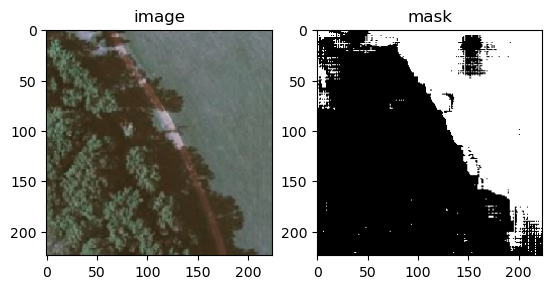

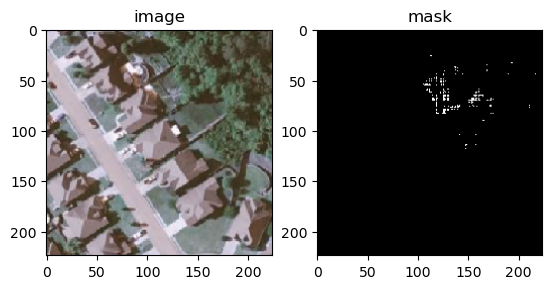

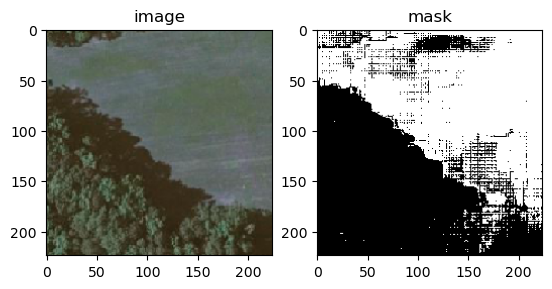

In [138]:
last_submit = pd.read_csv(f"{config['base_path']}/{file_name}")
submission_viewer(test_df, last_submit, 12)
submission_viewer(test_df, last_submit, 14)
submission_viewer(test_df, last_submit, 2)